In [3]:
!pip install plotly pandas 


  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.9 MB 961.0 kB/s eta 0:00:10
   --- ------------------------------------ 0.8/9.9 MB 1.3 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.9 MB 1.9 MB/s eta 0:00:05
   -------- ------------------------------- 2.1/9.9 MB 2.1 MB/s eta 0:00:04
   ----------- ---------------------------- 2.9/9.9 MB 2.4 MB/s eta 0:00:03
   -------------- ------------------------- 3.7/9.9 MB 2.6 MB/s eta 0:00:03
   --------------- ------------------------ 3.9/9.9 MB 2.5 MB/s eta 0:00:03
   ------------------ --------------------- 4.5/9.9 MB 2.4 MB/s eta 0:00:03
   ------------------- -------------------- 4.7/9.9 MB 2.4 MB/s eta 0:00:03
   -------------------- ------------------- 5.0/9.9 MB 2.1 MB/s eta 0:00:03
   -------------------- -------------

In [4]:
import sqlite3
import pandas as pd
import plotly.express as px

In [5]:
conn = sqlite3.connect("badge_attendance.db")


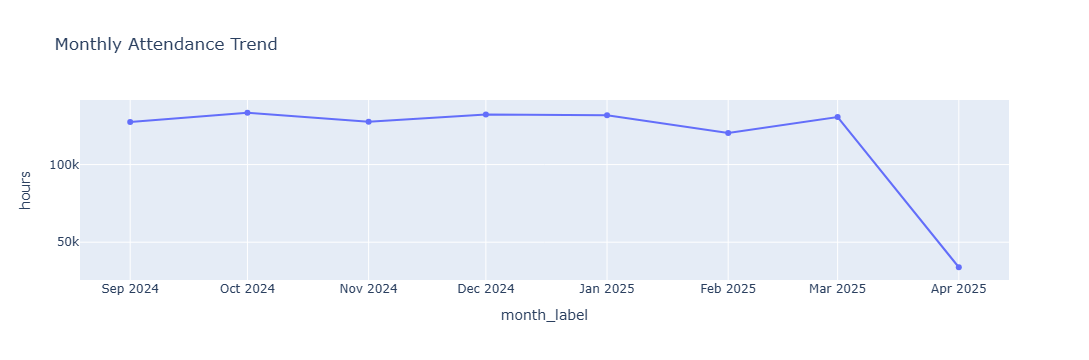

In [7]:
query = """
SELECT
    c.year,
    c.month,
    SUM(f.total_hours) as hours
FROM fact_attendance_daily f
JOIN dim_calendar c
ON f.date_id = c.date_id
GROUP BY c.year, c.month
ORDER BY c.year, c.month
"""

df_month = pd.read_sql(query, conn)

df_month["month_label"] = df_month["year"].astype(str) + "-" + df_month["month"].astype(str)

fig = px.line(df_month,
              x="month_label",
              y="hours",
              title="Monthly Attendance Trend",
              markers=True)

fig.show()
